Main paper referenced: <a href ="https://www.researchgate.net/publication/228580288_Solving_the_Travelling_Salesman_Problem_with_a_Hopfield-type_neural_network">Solving the Travelling Salesman Problem with a Hopfield-type neural network</a> (J. Mandziuk, 1996)

This is a modified Hopfield Network meant for solving the Travelling Salesman Problem (TSP) and other NP-hard problems, which is separate from the `hf_network` module. Note that an additional constant D is used for this problem when compared to solving the N-Queens Problem to consider the distance travelled between cities.

**Constants to be defined**: A, B, C, D, σ (for calculating energy); α (for calculating output potential)<br>**Main goal**: Using the shortest distance, pass through all cities exactly once and returning to the origin city at the end.<br>**Sub goal**: Minimize energy, E (defined in equations 5.1 and 5.2 in the original paper; different from what is described by Hopfield)

The following shows how training is conducted for the Hopfield Network:
![alt text](images/flow_chart.jpg)

Supposed solution for City Set 1 is as such:
![alt text](images/city_set_1.jpg)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class ModifiedHopfield:
    def __init__(self, *, number_of_objects, alpha, sigma, **kwargs):
        assert number_of_objects > 0
        
        self.number_of_objects = number_of_objects # refers to variable n
        self.alpha = alpha
        self.sigma = sigma
        self.constants = kwargs
        
        self.input_potential_shape = (self.number_of_objects,) * 2
        
    def solution(self):
        return self.output_potential > 0
        
    def output_potential_function(self, input_potential):
        # Output potential function is defined in equation 1
        return (1. + np.tanh(self.alpha * input_potential)) / 2
    
    def energy_function(self, *args):
        # Energy function is defined in equation 5
        E = 0
        
        # Expression 1: ensures that for each row in the output potential matrix, there would be at most one element equal to 1
        # In short, every object is visited not more than once
        E_1 = 0
        for x in range(self.number_of_objects):
            for i in range(self.number_of_objects):
                for j in range(self.number_of_objects):
                    if i != j:
                        E_1 += self.output_potential[x][i] * self.output_potential[x][j]
        E += self.constants["A"] / 2 * E_1
        
        # Expression 2: ensures that for each column in the output potential matrix, there would be at most one element equal to 1
        # In short, no more than one object is visited at any point in time
        E_2 = 0
        for i in range(self.number_of_objects):
            for x in range(self.number_of_objects):
                for y in range(self.number_of_objects):
                    if x != y:
                        E_2 += self.output_potential[x][i] * self.output_potential[y][i]
        E += self.constants["B"] / 2 * E_2
        
        # Expression 3: ensures that the sum of values in output potential matrix approach n, where n = number of objects / problem size
        E_3 = (self.output_potential.sum() - (self.number_of_objects + self.sigma)) ** 2
        E += self.constants["C"] / 2 * E_3
        
        # Expression 4: ensures that distance travelled is minimised
        E_4 = 0
        for x in range(self.number_of_objects):
            for y in range(self.number_of_objects):
                if x != y:
                    E_4 +=  args[0][x][y] * self.output_potential[x][0] * self.output_potential[y][1]
                    for i in range(1, self.number_of_objects - 1):
                        E_4 += args[0][x][y] * self.output_potential[x][i] * (self.output_potential[y][i + 1] + self.output_potential[y][i - 1])
                    E_4 +=  args[0][x][y] * self.output_potential[x][self.number_of_objects - 1] * self.output_potential[y][self.number_of_objects - 2]
        E += self.constants["D"] / 2 * E_4
        return E
    
    def train(self, *args, max_external_iterations = 25, max_external_iterations_with_constant_E = 5, strategy = "A", plot_energy_graph = False):
        assert len(args) == 0 or (len(args[0]) == self.number_of_objects and all([len(args[0][i]) == self.number_of_objects for i in range(self.number_of_objects)]))
        
        # Every n^2 repetitions of (ii) was called an internal iteration
        # Five internal iterations equates to one external iteration
        internal_iterations, external_iterations, external_iterations_with_constant_E = 0, 0, 0
        
        # (i) All initial output potentials were set
        # In simulation tests four strategies for setting initial output potentials were used.
        # a - random value from [0, 0.03]
        # b - random value from [0, 1]
        # c - random value from [1 - 0.03, 1]
        # d - random value from [0, 0.03] + 1/n
        self.input_potential = np.zeros(self.input_potential_shape) # refers to variable u
        self.output_potential = self.output_potential_function(self.input_potential) # refers to variable v
        if strategy == "A":
            self.output_potential = np.random.uniform(0, 0.03, self.input_potential_shape)
        elif strategy == "B":
            self.output_potential = np.random.uniform(0, 1, self.input_potential_shape)
        elif strategy == "C":
            self.output_potential = np.random.uniform(1 - 0.03, 1, self.input_potential_shape)
        elif strategy == "D":
            self.output_potential = np.random.uniform(0, 0.03, self.input_potential_shape) + 1 / self.number_of_objects
        
        # (i) Starting value of E was evaluated from equation 5
        energy_list = [self.energy_function(args[0])]
        
        while external_iterations_with_constant_E < max_external_iterations_with_constant_E and external_iterations < max_external_iterations:
            for _ in range(self.number_of_objects ** 2):
                # (ii) neuron[x][i] was chosen at random; basically asynchronous update is used
                x, i = np.random.randint(self.number_of_objects), np.random.randint(self.number_of_objects)
                
                # (ii) u[x][i] was calculated from equation 8
                self.input_potential[x][i] = - (self.constants["A"] * (self.output_potential[x].sum() - self.output_potential[x][i]) +\
                                                self.constants["B"] * (self.output_potential[:,i].sum() - self.output_potential[x][i]) +\
                                                self.constants["C"] * (self.output_potential.sum() - (self.number_of_objects + self.sigma)))
                if i == 0:
                    self.input_potential[x][i] -= self.constants["D"] * np.matmul(args[0][x], self.output_potential[:,1])
                elif i == self.number_of_objects - 1:
                    self.input_potential[x][i] -= self.constants["D"] * np.matmul(args[0][x], self.output_potential[:,self.number_of_objects - 2])
                else:
                    self.input_potential[x][i] -= self.constants["D"] * np.matmul(args[0][x], self.output_potential[:,i + 1] + self.output_potential[:,i - 1])
                # (ii) v[x][i] was calculated from equation 1
                self.output_potential[x][i] = self.output_potential_function(self.input_potential[x][i])
            
            internal_iterations += 1
            if internal_iterations % 5 == 0:
                external_iterations += 1
                energy = self.energy_function(args[0])
                if energy == energy_list[-1]:
                    external_iterations_with_constant_E += 1
                else:
                    external_iterations_with_constant_E = 0
                energy_list.append(energy)
            
        if plot_energy_graph is True:
            plt.plot([i for i in range(external_iterations + 1)], energy_list)
            plt.xlabel("Number of External Iterations")
            plt.ylabel("Energy")
            plt.annotate(f"min(E) = {int(energy_list[-1])}", (len(energy_list) - 1 + 0.01, energy_list[-1] + 0.01))
            plt.show()
            
        return energy_list[-1], internal_iterations, external_iterations

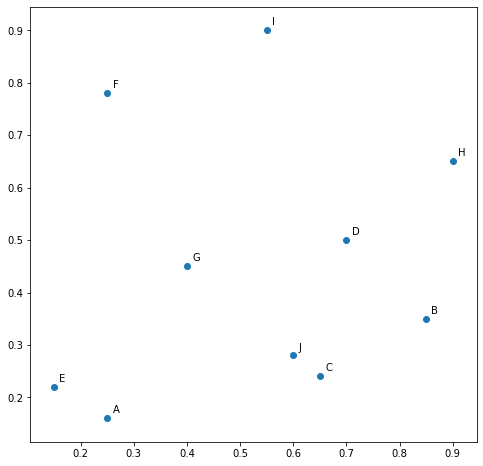

In [2]:
# As per City Set 1 defined in the paper
cities = [(0.25, 0.16), (0.85, 0.35), (0.65, 0.24), (0.70, 0.50), (0.15, 0.22), (0.25, 0.78), (0.40, 0.45), (0.90, 0.65), (0.55, 0.90), (0.60, 0.28)]
number_of_cities = len(cities)
distances = [[((city_2[0] - city_1[0]) ** 2 + (city_2[1] - city_1[1]) ** 2) ** 0.5 for city_2 in cities] for city_1 in cities]
labels = [chr(65 + i) for i in range(number_of_cities)]

plt.figure(figsize = (8, 8))
plt.scatter(*zip(*cities))
for i in range(number_of_cities):
    plt.annotate(labels[i], (cities[i][0] + 0.01, cities[i][1] + 0.01))
plt.show()

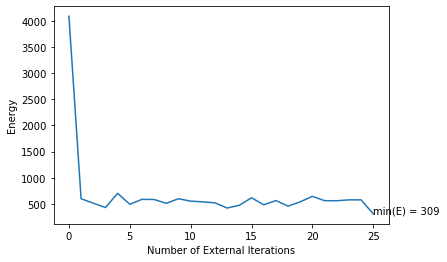

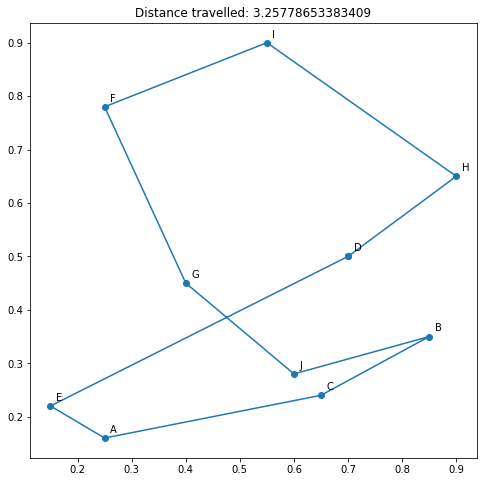

In [3]:
# Constants suggested by the paper, can be changed depending on situation
A, B, C, D, sigma = 100, 100, 90, 100, 1
alpha = 50
np.random.seed(123)

hopfield_network = ModifiedHopfield(number_of_objects = number_of_cities,
                                    alpha = alpha,
                                    sigma = sigma,
                                    A = A,
                                    B = B,
                                    C = C,
                                    D = D)

hopfield_network.train(distances,
                       max_external_iterations = 25,
                       max_external_iterations_with_constant_E = 5,
                       plot_energy_graph = True)

# In the resulting matrix, v[x][i] = 1 was interpreted as that city x was in position i of the salesman’s tour
solution = list(np.take(np.asarray(cities), np.where(hopfield_network.solution().T)[1], axis = 0))
solution.append(solution[0])
plt.figure(figsize = (8, 8))
plt.plot(*zip(*solution), "-o")
for i in range(number_of_cities):
    plt.annotate(labels[i], (cities[i][0] + 0.01, cities[i][1] + 0.01))
if len(solution) > number_of_cities:
    total_distance = sum([((solution[i][0] - solution[i + 1][0]) ** 2 + (solution[i][1] - solution[i + 1][1]) ** 2) ** 0.5 for i in range(number_of_cities)])
else:
    total_distance = None
plt.title(f"Distance travelled: {total_distance}")
plt.show()

Supposedly, for A = B = 100 (unchanged constants), C = 90, D = 100, sigma = 1, alpha = 50, Mandziuk produced the following results:
![alt text](images/results.jpg)

In [4]:
# 100 simulation tests are conducted to make comparison with the original paper
import pandas as pd
from tqdm.auto import tqdm

A, B, C, D, sigma = 100, 100, 90, 100, 1
alpha = 50
strategies = ["A", "B", "C", "D"]

hopfield_network = ModifiedHopfield(number_of_objects = number_of_cities,
                                    alpha = alpha,
                                    sigma = sigma,
                                    A = A,
                                    B = B,
                                    C = C,
                                    D = D)

number_of_tests = 100
distance_list, iterations_list = [], []
for strategy in strategies:
    np.random.seed(123)
    distance_list.append([])
    iterations_list.append([])
    for _ in tqdm(range(number_of_tests), desc = f"Strategy {strategy}"):
        energy, internal_iterations, external_iterations = hopfield_network.train(distances,
                                                                                  max_external_iterations = float("inf"),
                                                                                  max_external_iterations_with_constant_E = 5,
                                                                                  strategy = strategy)
        iterations_list[-1].append(external_iterations)
        solution = list(np.take(np.asarray(cities), np.where(hopfield_network.solution().T)[1], axis = 0))
        solution.append(solution[0])
        if len(solution) > number_of_cities:
            distance_list[-1].append(sum([((solution[i][0] - solution[i + 1][0]) ** 2 + (solution[i][1] - solution[i + 1][1]) ** 2) ** 0.5 for i in range(number_of_cities)]))
        
result = [[round(min(distance_list[i]), 3), round(sum(distance_list[i]) / len(distance_list[i]), 3), round(max(distance_list[i]), 3), len(distance_list[i]) * 100 // number_of_tests, round(sum(iterations_list[i]) / number_of_tests, 1)] for i in range(len(strategies))]

pd.DataFrame(result, strategies, ["Best", "Mean", "Worst", "%Succ.", "Iter."])

Strategy A:   0%|          | 0/100 [00:00<?, ?it/s]

Strategy B:   0%|          | 0/100 [00:00<?, ?it/s]

Strategy C:   0%|          | 0/100 [00:00<?, ?it/s]

Strategy D:   0%|          | 0/100 [00:00<?, ?it/s]

,Best,Mean,Worst,%Succ.,Iter.
A,2.786,3.426,4.090,100,50.4
B,2.786,3.421,4.070,100,51.2
C,2.787,3.496,4.373,100,48.9
D,2.787,3.413,4.117,100,50.9
